## Imports & Data

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
import random
import numpy as np
import pandas as pd
import pickle
import os, sys
from matplotlib import pyplot as plt

%matplotlib inline
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
pd.set_option('display.max_columns', 100)  # or however many you want
pd.set_option('display.max_rows', 200)
print("Project root:", project_root)

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=10
seed_everything(seed)

cpu
Project root: /Users/alex/Desktop/TrustWorthyXAILocaltoGlobal


In [2]:
filename="500ktest_dataset_lar.csv"
script_dir = os.path.dirname('__file__')
data_path = os.path.join(script_dir, '..', 'datasets', filename)
data_path = os.path.abspath(data_path)
print(data_path)
df=pd.read_csv(data_path)
df.head(10)

/Users/alex/Desktop/TrustWorthyXAILocaltoGlobal/datasets/500ktest_dataset_lar.csv


/var/folders/b0/ymr48tf963d9_3y2jfmn5wfw0000gn/T/ipykernel_4485/349837994.py:6: DtypeWarning: Columns (23,24,25,27,28,29,30,31,32,37,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path)


,Unnamed: 0,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open_end_line_of_credit,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,origination_charges,discount_points,lender_credits,loan_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co_applicant_credit_score_type,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_ethnicity_observed,co_applicant_ethnicity_observed,applicant_race_1,co_applicant_race_1,applicant_race_observed,co_applicant_race_observed,applicant_sex,co_applicant_sex,applicant_sex_observed,co_applicant_sex_observed,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus_1,denial_reason_1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,98395,2024,549300ZX4OGRPOOEH505,28140,KS,20209.0,2.020904e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Female,1,0,2,1,31,1,2,2,2,125000,90.0,3.18,-4.925,2,984.0,0.0,NaN,NaN,360.0,12.0,2,2,2,2,135000.0,1,1,3,5,1,NaN,37,2,10,1.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,25-34,9999,No,NaN,1,1,6,10,1125,77.69,103000,0.0,197,398,43
1,55868,2024,5493000NYUJT9UC6G261,45294,FL,12101.0,1.210103e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,2,1,32,1,2,2,2,205000,80.0,7.49,0.947,2,7515.0,4865.0,3120.0,NaN,360.0,NaN,2,2,2,2,265000.0,1,1,3,5,1,76.0,30%-<36%,3,10,2.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,2,10,5067,39.73,88800,155.0,1401,1824,0
2,90858,2024,5493006MW6O2CE88BD43,39820,CA,6089.0,6.089011e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,3,0,2,1,2,2,2,2,2,25000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,NaN,1,1,3,5,1,47.0,50%-60%,9,10,2.0,5.0,1,4,5.0,8.0,1,4,2,5,1,4,65-74,9999,Yes,NaN,1,1,6,1,3467,23.74,89100,139.0,948,1242,34
3,12143,2024,549300157R33LDICP344,99999,OH,39021.0,3.902101e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,1,71,2,2,1,1,2,2,2,215000,96.50000,6.500,1.310,2,7630.81,2125.00,NaN,527.76,360,NaN,2,2,2,2,215000,1,1,3,5,1,67.0,46,1,10,2.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,25-34,9999,No,NaN,1,1,3,10,3714,16.32,81600,105.0,993,1474,59
4,4785,2024,ZF85QS7OXKPBG52R7N18,33340,WI,55079.0,5.507902e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,4,0,2,1,1,1,2,2,2,205000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,360,NaN,2,2,2,2,NaN,1,1,3,5,1,60.0,NaN,9,9,2.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,1,10,4145,22.46,102100,91.0,1337,1944,74
5,2289,2024,ZF85QS7OXKPBG52R7N18,24580,WI,55009.0,5.500900e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Joint,3,0,2,1,1,1,2,2,2,295000,97,NaN,NaN,3,NaN,NaN,NaN,NaN,360,NaN,2,2,2,2,305000,1,1,3,5,1,86.0,36,1,9,1.0,1.0,2,2,5.0,5.0,2,2,1,2,2,2,25-34,25-34,No,No,1,1,1,3,8553,31.35,96900,106.0,2394,2781,43
6,53185,2024,5493000NYUJT9UC6G261,16984,IL,17197.0,1.719788e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Male,1,71,2,2,1,1,2,2,2,215000,90.0,6.75,1.339,2,9835.5,1690.0,NaN,NaN,360.0,NaN,2,2,2,2,235000.0,1,1,3,5,1,57.0,49,1,10,1.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,1,10,4057,67.44,

## Data Processing

In [63]:
target='action_taken'
print("Number of NaNs:", df[target].isna().sum())
print(f"Target distribution:\n{df[target].value_counts().sort_index()}")
print("First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. ")
df = df[~df["action_taken"].isin([4,5,6,7,8])].copy()
print(f"This leaves us with {len(df)} rows")
#Next we combine categories 1 and 2 because they both indicate the loan was approved.
print("Combining categories 1 and 2 because they both indicate loan approval")
df['action_taken']=df['action_taken'].isin([1,2]).astype(int)
print(f"Binary target distribution:\n{df[target].value_counts().sort_index()}")

Number of NaNs: 0
Target distribution:
action_taken
1    252377
2     14605
3     85576
4     62995
5     23941
6     52115
7      1963
8      6317
Name: count, dtype: int64
First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. 
This leaves us with 352558 rows
Combining categories 1 and 2 because they both indicate loan approval
Binary target distribution:
action_taken
0     85576
1    266982
Name: count, dtype: int64


### Unused/Optional Features
1. Census features are optional because they are appended to the public HMDA data after collection, and thus are not used in initial loan approval
2. Irrelevant features are dropped because they consist of categories such as AUS1 (the automated underwriting system(s) (AUS) used by the financial institution to evaluate the application) which ideally should have no impact on an application because they are not borrower statistics. Other lender choice features also include credit score type, which the borrower does not know. 
3. Data Leakage features contain information that is only available after loan approval. For example, the 'intro_rate_period' which only exists when the loan reaches the underwriting stage, or 'denial_reason_1' which only exists when applications are denied. However, these might be good for explainability reasons in post-training.
4. Demographic features are protected features such as sex, race and age. These features are removed from the model to ensure compliance with regulations ('Equal Credit Opportunity Act') which prevent them from being used in a credit decision. However, we acknowledging that this demographic-blind approach may still leave residual bias, which is beyond the scope of this project in interpretability.

In [64]:
#to_process
census_features=['tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units']
irrelevant_feat = ['aus_1','submission_of_application', 'Unnamed: 0', 'activity_year', 'applicant_credit_score_type', 'co_applicant_credit_score_type', 'lei']
leakage_feat=["denial_reason_1", "interest_rate",       
    "total_loan_costs",   
    "origination_charges", 
    "discount_points",     
    "lender_credits",       
    'rate_spread', 'hoepa_status', 'purchaser_type']
protected_feat=['derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_ethnicity_1',
       'co_applicant_ethnicity_1', 'applicant_ethnicity_observed',
       'co_applicant_ethnicity_observed', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_race_observed',
       'co_applicant_race_observed', 'applicant_sex', 'co_applicant_sex',
       'applicant_sex_observed', 'co_applicant_sex_observed', 'applicant_age',
       'co_applicant_age', 'applicant_age_above_62',
       'co_applicant_age_above_62']


feature='denial_reason_1' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: (x==10).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.\n")

feature='rate_spread' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.\n")

feature='lender_credits'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='purchaser_type'
missing=df.groupby(target)[feature].apply(lambda x: (x==0).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='interest_rate'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")

Percentage of missing values of denial_reason_1 per action_taken:
 action_taken
0    0.000000
1    0.972174
Name: denial_reason_1, dtype: float64
We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.

Percentage of missing values of rate_spread per action_taken:
 action_taken
0    0.985019
1    0.093939
Name: rate_spread, dtype: float64
We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.

Percentage of missing values of lender_credits per action_taken:
 action_taken
0    0.984844
1    0.752414
Name: lender_credits, dtype: float64
Number of NaNs: 285160
lender_credits
Exempt    10204
1000.0      679
500.0       604
500.00      378
50.0        346
Name: count, dtype: int64 

Percentage of missing values of purchaser_type per action_taken:
 action_taken
0    1.000000
1    0.436119
Name: purchaser_type, dtype: float64
Number of NaNs: 0
purchaser_type
0     202012
71     33763


In [65]:
#Dropping the above features
todrop=census_features+irrelevant_feat+leakage_feat+protected_feat
df_cleaned=df.drop(columns=todrop)
df_cleaned.head(20)
print(f"There are now {len(df_cleaned.columns)} features for prediction in this cleaned dataset.")
print(df_cleaned.columns)
print(f"Each feature in this list is manually examined and sorted into categories outlined in the next section before encoding. We also discovered existence of mixed data types in various columns that are dealt with via feature engineering.")
missing_val_info={'placeholder':{},
                  'count':{}}


There are now 32 features for prediction in this cleaned dataset.
Index(['derived_msa_md', 'state_code', 'county_code', 'census_tract',
       'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'action_taken', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open_end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'combined_loan_to_value_ratio', 'loan_term',
       'intro_rate_period', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'debt_to_income_ratio', 'initially_payable_to_institution'],
      dtype='object')
Each feature in this list is manually examined and sorted into categories outlined in the next section before en

### Note on Exempt and NaN datapoints:

This dataset contains a number of values labeled as “Exempt”, which occur because financial institutions are permitted to withhold certain information. These exempt values can be treated as NaN for analysis purposes.

Other NaN or not applicable datapoints may arise either because the information was not provided or because it does not apply to that particular loan category. For example, fixed-rate mortgages do not have an introductory rate period, so missing values in this field are expected.

In some categorical variables, missing or not applicable values may also be encoded as special codes, such as 1111 or 9999. Handling of these cases is described on a case-by-case basis in the following section.

### Case1.1: Low Dimensional Categoricals

In [66]:
low_dim_cat=['occupancy_type', 'manufactured_home_land_property_interest', 'manufactured_home_secured_property_type', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'loan_type', 'loan_purpose', 'lien_status', 'initially_payable_to_institution']

#ToDrop:
todrop_redundant=[]
counts = df_cleaned.groupby(['loan_type', 'lien_status'])['derived_loan_product_type'].nunique()
print("The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.")
print(counts)
todrop_redundant.append('derived_loan_product_type')

counts = df_cleaned.groupby(['construction_method', 'total_units'])['derived_dwelling_category'].nunique()
print("\nThe derived_dwelling_category is also a join from the Construction Method and Total Units fields.")
print(counts)
todrop_redundant.append('derived_dwelling_category')

df_cleaned=df_cleaned.drop(columns=todrop_redundant)
low_dim_cat=[j for j in low_dim_cat if j not in todrop_redundant]

The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.
loan_type  lien_status
1          1              1
           2              1
2          1              1
           2              1
3          1              1
4          1              1
           2              1
Name: derived_loan_product_type, dtype: int64

The derived_dwelling_category is also a join from the Construction Method and Total Units fields.
construction_method  total_units
1                    1              1
                     2              1
                     3              1
                     4              1
                     1              1
                     100-149        1
                     2              1
                     25-49          1
                     3              1
                     4              1
       

In [67]:
print(df_cleaned[low_dim_cat].isna().sum(), '\n')
for j in low_dim_cat:
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())
    if j=='manufactured_home_land_property_interest':
        missing_val_info['placeholder'][j]=[1111]
    elif j=='manufactured_home_secured_property_type':
        missing_val_info['placeholder'][j]=[1111]
    elif j=='loan_purpose':
        missing_val_info['placeholder'][j]=[4, 5]
    elif j=='initially_payable_to_institution':
        missing_val_info['placeholder'][j]=[3, 1111]

occupancy_type                                 0
manufactured_home_land_property_interest       0
manufactured_home_secured_property_type        0
conforming_loan_limit                       1568
loan_type                                      0
loan_purpose                                   0
lien_status                                    0
initially_payable_to_institution               0
dtype: int64 

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: object
conforming_loan_limit
C     340967
NC      9975
U         48
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2  

A cursory examination of the data ranges shows us that all columns are already in consistent data types. Since tabnet takes either integers or strings for categoricals. Cross-checking against data schema, we will leave the Exempt entries, encoded as 1111 in hopes tabnet can pick up these values. We will also convert the np.nan and U entries into 1111 as well.

In [68]:

replace_map = {
    'conforming_loan_limit': {np.nan: 1111,
                              'C': 1,
                              'NC': 0,
                              'U': 1111}
}
missing_val_info['placeholder']['conforming_loan_limit']=[1111]
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for j in low_dim_cat:
    df_cleaned[j]=df_cleaned[j].astype(int)
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())
        

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: int64
conforming_loan_limit
1       340967
0         9975
1111      1616
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2     45136
3     25191
4      1824
Name: count, dtype: int64
Column data type: int64
loan_purpose
1     175184
32     49382
4      46260
2      41701
31     39888
5        143
Name: count, dtype: int64
Column data type: int64
lien_status
1    255164
2     97394
Name: count, dtype: int64
Column data type: int64
initially_payable_to_institution
1       318303
2        17024
1111     10156
3         7075

/var/folders/b0/ymr48tf963d9_3y2jfmn5wfw0000gn/T/ipykernel_88602/2793523652.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned=df_cleaned.replace(replace_map, inplace=False)


### Case 1.2: Categoricals Features with High Dimension
This is basic categorical data that requires usage of embeddings due to high dimensionality. The embedding is naturally dealt with by tabnet by passing as integers.

In [69]:
high_dim_cat=['derived_msa_md', 'census_tract', 'county_code', 'state_code']
feature=high_dim_cat[1]
for feature in high_dim_cat:
    print(df_cleaned[feature].value_counts().head(5))
    print("Column data type:", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(f"Number of dimensions: {len(df_cleaned[feature].value_counts())}")

#Drop census_tract due to high dimensionality, since it is a location variable which is too granular, and we already have other location variables
df_cleaned=df_cleaned.drop(columns=['census_tract', 'county_code'])
high_dim_cat.remove('census_tract')
high_dim_cat.remove('county_code')
df_cleaned['state_code']=df_cleaned['state_code'].fillna('Unknown')
missing_val_info['placeholder']['state_code']=['Unknown']
missing_val_info['placeholder']['derived_msa_md']=[99999]
#print(min(df_cleaned['county_code'].value_counts().index))


derived_msa_md
99999    48153
26420     6841
38060     6601
16984     6286
12054     6233
Name: count, dtype: int64
Column data type: int64
Number of NaNs: 0
Number of Exempt: 0
Number of dimensions: 418
census_tract
4.815767e+10    139
4.820154e+10    111
1.210103e+10     99
1.209502e+10     99
4.808503e+10     97
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 4876
Number of Exempt: 0
Number of dimensions: 74587
county_code
6037.0     5900
4013.0     5723
17031.0    4164
48201.0    3472
6065.0     2806
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 3589
Number of Exempt: 0
Number of dimensions: 3105
state_code
CA    29762
FL    29233
TX    28551
NC    14477
OH    14143
Name: count, dtype: int64
Column data type: object
Number of NaNs: 1850
Number of Exempt: 0
Number of dimensions: 54


In [70]:
categoricals=high_dim_cat+low_dim_cat
print(len(categoricals))
print(categoricals)
for feature in missing_val_info['placeholder'].keys():
    missing_val_info['count'][feature]=df_cleaned[feature].isin(missing_val_info['placeholder'][feature]).sum()


10
['derived_msa_md', 'state_code', 'occupancy_type', 'manufactured_home_land_property_interest', 'manufactured_home_secured_property_type', 'conforming_loan_limit', 'loan_type', 'loan_purpose', 'lien_status', 'initially_payable_to_institution']


### Case 2.1: Continuous Data
This is basic continuous numerical data without the "Exempt" value

In [71]:
pd_to_numeric=['income', 'loan_amount']
for feature in pd_to_numeric:
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)
    print(f"Feature: {feature}")
    print("Data type: ", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(10))
    print("\n")
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()

Feature: income
Data type:  float32
Number of NaNs: 22214
Number of Exempt: 0
income
0.0      4656
60.0     3023
75.0     2975
100.0    2963
80.0     2904
90.0     2820
70.0     2726
65.0     2692
120.0    2681
72.0     2675
Name: count, dtype: int64


Feature: loan_amount
Data type:  float32
Number of NaNs: 0
Number of Exempt: 0
loan_amount
55000.0     17448
105000.0    16934
75000.0     11264
65000.0     10842
155000.0    10469
35000.0     10060
205000.0    10007
45000.0      9840
25000.0      9529
85000.0      8904
Name: count, dtype: int64




### Case2.2: Continuous with Exempt:
Continuous data with the exempt keyword. In this case, we can treat the same as nan as we gain no meaningful information from the missing data. 

In [72]:
continuous_with_exempt=['intro_rate_period', 'combined_loan_to_value_ratio', 'property_value', 'loan_term']
for feature in continuous_with_exempt:
    print(f"Feature: {feature}")
    print("Data type: ", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(10))
    print("\n")
for feature in continuous_with_exempt:
    df_cleaned[feature]=df_cleaned[feature].replace("Exempt", np.nan)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)

Feature: intro_rate_period
Data type:  object
Number of NaNs: 264480
Number of Exempt: 10149
intro_rate_period
1.0       33945
1         11426
Exempt    10149
1.0        3382
84.0       3072
6.0        2928
60.0       2856
60         2388
12.0       2289
12         2257
Name: count, dtype: int64


Feature: combined_loan_to_value_ratio
Data type:  object
Number of NaNs: 26931
Number of Exempt: 10131
combined_loan_to_value_ratio
80.0        17164
96.5        10787
Exempt      10131
100.0        7937
95.0         7873
75.0         6101
90.0         5244
80.00000     4616
80.0         4254
70.0         3311
Name: count, dtype: int64


Feature: property_value
Data type:  object
Number of NaNs: 13105
Number of Exempt: 10187
property_value
Exempt      10187
305000.0     4431
355000.0     4331
255000.0     4100
325000.0     4080
275000.0     3873
265000.0     3738
295000.0     3696
335000.0     3693
285000.0     3690
Name: count, dtype: int64


Feature: loan_term
Data type:  object
Number of N

### Case 2.2: Continuous With Range:
These are features that are a hybrid of numerical values and numerical ranges. When there are small ranges, we replace with midpoint. When they are extremal ranges, we replace with the extremal endpoints. Rows that already contain a direct numeric value are left unchanged, preserving the available precision.

This approach is motivated by the observation that lender decisions appear to require greater granularity within certain ranges, such as the 36–50 range for debt-to-income ratio. For other ranges, such as 20–30 or 30–36, grouping values into a single representative number is reasonable, as the decision process likely treats applicants within these ranges similarly.

In [73]:
numericwithranges_and_exempt=['debt_to_income_ratio', 'total_units']
for feature in numericwithranges_and_exempt:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(20))
replace_map={'debt_to_income_ratio': {'30%-<36%': 33,
                                      '20%-<30%': 25,
                                      "50%-60%": 55, 
                                      '>60%': 80, 
                                      '<20%': 10, 
                                      'Exempt': np.nan},
            'total_units': {'5-24': 29/2,
                            '25-49': (25+49)/2,
                            '50-99': (50+99)/2,
                            '100-149': (100+149)/2,
                            '>149': 200, 
                            }
}
#
print("\n After: ")
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for col in numericwithranges_and_exempt:
    df_cleaned[col]=df_cleaned[col].astype(np.float32)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()
    print(df_cleaned[col].value_counts().head(20))

Number of NaNs: 28365
Number of Exempt: 10122
debt_to_income_ratio
30%-<36%    43806
20%-<30%    42901
50%-60%     32723
>60%        24789
<20%        18704
49          15678
44          12939
42          12642
43          11142
41          10899
40          10635
48          10443
Exempt      10122
39          10107
45           9967
47           9768
46           9652
38           9532
37           8941
36           8803
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
total_units
1          316318
1           25369
2            6181
3            1440
5-24         1042
4            1007
2             513
25-49         172
>149          145
50-99         137
3              88
4              74
100-149        72
Name: count, dtype: int64

 After: 
debt_to_income_ratio
33.0    43806
25.0    42901
55.0    32723
80.0    24789
10.0    18704
49.0    15678
44.0    12939
42.0    12642
43.0    11142
41.0    10899
40.0    10635
48.0    10443
39.0    10107
45.0     9967
47.0     9

In [74]:
numeric=pd_to_numeric+numericwithranges_and_exempt+continuous_with_exempt
for feature in missing_val_info['placeholder'].keys():
    if missing_val_info['count'][feature]:
        pass
    else:
        missing_val_info['count'][feature]=df_cleaned[feature].isin(missing_val_info['placeholder'][feature]).sum()
print(len(numeric))

8


### Case 3.1: Boolean Data
Simple boolean data

In [75]:
boolean=['preapproval', 'construction_method']
for feature in boolean:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(5))
for feature in boolean:
    df_cleaned[feature]=df_cleaned[feature].astype(int)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=0

Number of NaNs: 0
Number of Exempt: 0
preapproval
2    344525
1      8033
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
construction_method
1    332140
2     20418
Name: count, dtype: int64


### Case 3.2: Boolean With Exempt
The 1111 datafield is equivalent to the Exempt keyword in other columns, so can be treated as equivalent to NA. However, the entry 3 indicates that the loan is not a manufactured-home loan, so this field does not apply. There are clearly no np.nan values, all have been converted to 1111 already.

In [76]:
boolean_with_exempt=['reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features']
for feature in boolean_with_exempt:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(200))
    df_cleaned[feature]=df_cleaned[feature].astype(int)
    missing_val_info['placeholder'][feature]=[1111]
    missing_val_info['count'][feature]=(df_cleaned[feature]==1111).sum()
    

Number of NaNs: 0
Number of Exempt: 0
reverse_mortgage
2       341000
1111     10175
1         1383
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
open_end_line_of_credit
2       265441
1        76991
1111     10126
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
business_or_commercial_purpose
2       322472
1        19924
1111     10162
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
negative_amortization
2       341661
1111     10193
1          704
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
interest_only_payment
2       295735
1        46630
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
balloon_payment
2       327609
1        14756
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
other_nonamortizing_features
2       341356
1111     10193
1         1009
Name: count, dtype: int64


In [77]:
#categoricals=list(set(categoricals+boolean+boolean_with_exempt))
categoricals=list(set(categoricals+boolean+boolean_with_exempt)) # need to figure out how to deal with sparsity in nnumericals
categoricals.sort()
features=categoricals
df_cleaned=df_cleaned[features+[target]]
print(f"As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {set(df_cleaned.columns)-set(features)}. This is the target variable as expected.")

As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {'action_taken'}. This is the target variable as expected.


## Training

In [78]:
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.head()


,balloon_payment,business_or_commercial_purpose,conforming_loan_limit,construction_method,derived_msa_md,initially_payable_to_institution,interest_only_payment,lien_status,loan_purpose,loan_type,manufactured_home_land_property_interest,manufactured_home_secured_property_type,negative_amortization,occupancy_type,open_end_line_of_credit,other_nonamortizing_features,preapproval,reverse_mortgage,state_code,action_taken
0,2,2,1,1,28140,1,2,1,31,1,5,3,2,1,2,2,2,2,KS,1
1,2,2,1,1,45294,1,2,1,32,1,5,3,2,1,2,2,2,2,FL,1
2,2,2,1,1,39820,1,2,2,2,1,5,3,2,1,2,2,2,2,CA,0
3,2,2,1,1,99999,1,2,1,1,2,5,3,2,1,2,2,2,2,OH,1
4,2,2,1,1,24580,1,2,1,1,1,5,3,2,1,2,2,2,2,WI,0


In [79]:
#Encode Categoricals
from sklearn.preprocessing import LabelEncoder
categorical_columns=categoricals
categorical_dims={col: len(df_cleaned[col].value_counts()) for col in categorical_columns}
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
j=[]
for col in categorical_columns:
    l_enc = LabelEncoder()
    df_cleaned[col]=l_enc.fit_transform(df_cleaned[col].values)
print(cat_dims)

[3, 3, 3, 2, 418, 4, 3, 2, 6, 4, 6, 4, 3, 3, 3, 3, 2, 3, 55]


In [80]:
#Train Test Split
if "trainingset" not in df_cleaned.columns:
    df_cleaned["trainingset"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df_cleaned.shape[0],))
train_indices = df_cleaned[df_cleaned['trainingset']=="train"].index
valid_indices = df_cleaned[df_cleaned['trainingset']=="valid"].index
test_indices = df_cleaned[df_cleaned['trainingset']=="test"].index
df_cleaned=df_cleaned.drop(columns=['trainingset'])
X_train = df_cleaned[features].values[train_indices]
y_train = df_cleaned[target].values[train_indices]

X_valid = df_cleaned[features].values[valid_indices]
y_valid = df_cleaned[target].values[valid_indices]

X_test = df_cleaned[features].values[test_indices]
y_test = df_cleaned[target].values[test_indices]

for col in categorical_columns:
    train_vals = set(df_cleaned.loc[train_indices, col].dropna().unique())
    test_vals  = set(df_cleaned.loc[test_indices,  col].dropna().unique())

    unseen = test_vals - train_vals
    if unseen:
        print(f"Unseen categories in test for {col}: {unseen}")
    else:
        print(f"✓ {col}: all good")
print(len(X_train), len(X_valid), len(X_test))

✓ balloon_payment: all good
✓ business_or_commercial_purpose: all good
✓ conforming_loan_limit: all good
✓ construction_method: all good
✓ derived_msa_md: all good
✓ initially_payable_to_institution: all good
✓ interest_only_payment: all good
✓ lien_status: all good
✓ loan_purpose: all good
✓ loan_type: all good
✓ manufactured_home_land_property_interest: all good
✓ manufactured_home_secured_property_type: all good
✓ negative_amortization: all good
✓ occupancy_type: all good
✓ open_end_line_of_credit: all good
✓ other_nonamortizing_features: all good
✓ preapproval: all good
✓ reverse_mortgage: all good
✓ state_code: all good
281900 35184 35474


In [81]:
import torch.nn.functional as F
neg=len(df_cleaned[df_cleaned['action_taken']==0])/len(df_cleaned)
weights=[neg, 1-neg]
print(weights)
class_weights = torch.tensor([1/weights[0], 1/weights[1]])
def Weighted_CE(input, target):
    return F.cross_entropy(input, target, weight=class_weights)

def Weighted_CE_per_batch(input, target):
    """
    input: logits [batch_size, 2]
    target: class indices [batch_size]
    """
    batch_size = target.size(0)
    num_class0 = (target == 0).sum().item()
    num_class1 = (target == 1).sum().item()
    
    # Avoid division by zero
    num_class0 = max(num_class0, 1)
    num_class1 = max(num_class1, 1)
    
    # Class weights inversely proportional to frequency in this batch
    weight = torch.tensor([batch_size/num_class0, batch_size/num_class1], dtype=torch.float, device=input.device)
    
    # Compute CE with these per-batch weights
    return F.cross_entropy(input, target, weight=weight, reduction='mean')

[0.24272885596128863, 0.7572711440387114]


In [82]:
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
tabnet_classifier_params={
                'n_d': 16,
                'n_a': 16,
                'n_steps': 7,
                'gamma': 1.65,
                'lambda_sparse': 1e-3,
                'momentum': 0.015,
                "cat_idxs":cat_idxs,
                "cat_dims":cat_dims,
                "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
                "optimizer_fn":torch.optim.Adam,
                "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
                "scheduler_params":{    "step_size":15,
                                        "gamma": 0.35},
                "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                "mask_type":'entmax', # "sparsemax"
                }

model=TabNetClassifier(**tabnet_classifier_params)

model.fit_with_epochFI(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['auc', 'accuracy', 'balanced_accuracy', 'logloss'],
    max_epochs=200 ,
    patience=40, # please be patient ^^
    loss_fn=Weighted_CE_per_batch,
    batch_size=1024,
    virtual_batch_size=512,
    num_workers=1,
    drop_last=False,
    compute_importance=True
)
# model.fit(
#     X_train=X_train, y_train=y_train,
#     eval_set=[(X_valid, y_valid)],
#     eval_name=['valid'],
#     eval_metric=['auc', 'accuracy', 'balanced_accuracy', 'logloss'],
#     max_epochs=100 ,
#     patience=30, # please be patient ^^
#     loss_fn=Weighted_CE_per_batch,
#     batch_size=1024,
#     num_workers=1,
#     drop_last=False,
#     compute_importance=True
# )
saved=model.save_model('test_model')



/Users/alex/Desktop/TrustWorthyXAILocaltoGlobal/utilities/models/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


<class 'torch.optim.lr_scheduler.StepLR'> has metric: False


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/__init__.py", line 2151, in <module>
    from torch import (
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nested/__init__.py", line 21, in <module>
    from ._internal.nested_tensor import NestedTensor as _NestedTensor, _rebuild_njt
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nested/_internal/nested_tensor.py", line 8, in <module>
    from torch.nested._internal.nested_int import NestedIntNode
  F

KeyboardInterrupt: 

In [ ]:
# 1️⃣ Loss
plt.figure(figsize=(8,5))
plt.plot(model.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2️⃣ AUC
plt.figure(figsize=(8,5))
plt.plot(model.history['valid_auc'], label='Valid AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# 3️⃣ Accuracy
plt.figure(figsize=(8,5))
plt.plot(model.history['valid_accuracy'], label='Valid Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Feature Importance Drift Smoothed + Non Smoothed
def plot_fi(fi, title="TabNet Feature Importances Over Training", feats=features):
    """fi should have shape (epochs, #numfeatures)"""
    num_epochs, num_features = fi.shape
    assert num_features==len(feats)
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 8))

    for feature_idx in range(num_features):
        plt.plot(epochs, fi[:, feature_idx], label=f"Feature {feats[feature_idx]}")

    plt.xlabel("Epoch")
    plt.ylabel("Feature Importance")
    plt.title(title)
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()  
from scipy.ndimage import gaussian_filter1d
fi = np.array(model.feature_importances_history)
plot_fi(fi, feats=features)
fi_smooth = gaussian_filter1d(fi, sigma=1.2, axis=0)
plot_fi(fi_smooth, title="Smoothed TabNet Feature Importances over Epochs", feats=features)

torch.save(fi, "feature_importance_drift_over_epochs")

Pick an Epoch (Reload model here if it crashes during influence)

In [83]:
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
epoch=46
epoch_path = f"models_/epoch_{epoch}.zip"
tabnet_classifier_params={
                'n_d': 16,
                'n_a': 16,
                'n_steps': 7,
                'gamma': 1.65,
                'lambda_sparse': 1e-3,
                'momentum': 0.015,
                "cat_idxs":cat_idxs,
                "cat_dims":cat_dims,
                "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
                "optimizer_fn":torch.optim.Adam,
                "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
                "scheduler_params":{    "step_size":15,
                                        "gamma": 0.35},
                "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                "mask_type":'entmax', # "sparsemax"
                }
model=TabNetClassifier(**tabnet_classifier_params)
model.load_model(epoch_path)


/Users/alex/Desktop/TrustWorthyXAILocaltoGlobal/utilities/models/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


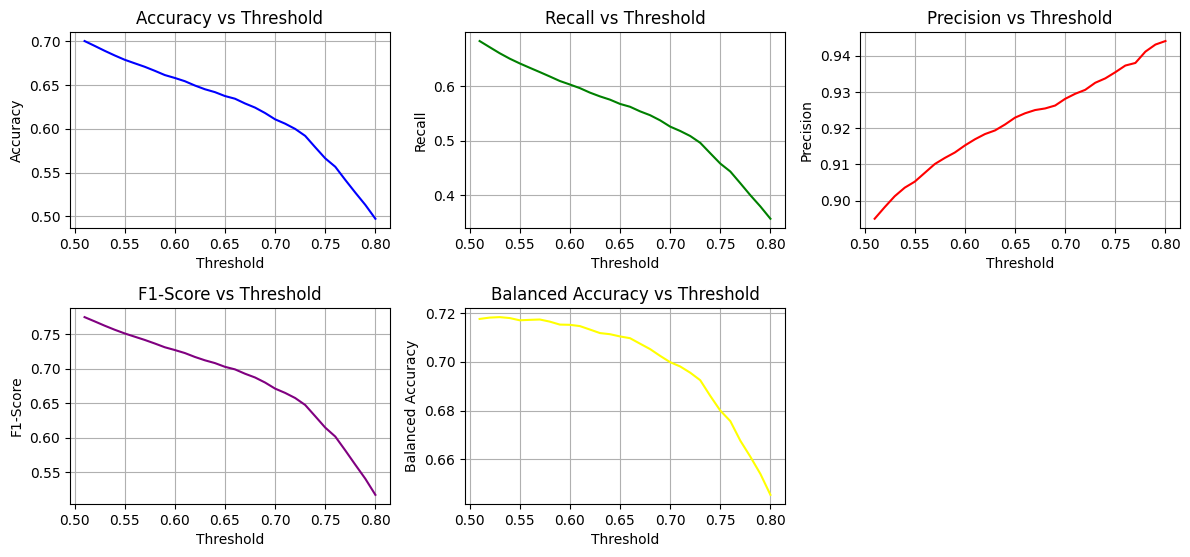

FINAL TEST SCORE for threshold 0.58:
Accuracy: 0.6660652872526357
Recall: 0.617941066766132
Precision: 0.9117776554760595
F1-Score: 0.7366385060026678


In [25]:

#Prediction:
from sklearn.metrics import confusion_matrix
thresholds=[0.5+j*0.01 for j in range(1, 31)]
accuracies = []
recalls = []
precisions = []
f1_scores = []
balanced_accs=[]
for threshold in thresholds:
    y_pred=model.predict(X_test, threshold=threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy=(tn+tp)/(tn+fp+fn+tp)
    recall=tp / (tp + fn)
    precision=tp / (tp + fp)
    specificity=tn/(tn+fp)
    f1score=2*(precision*recall)/(precision+recall)
    balanced_acc=(recall+specificity)/2
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1score)
    balanced_accs.append(balanced_acc)
# Plot the metrics
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(3, 3, 1)
plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)

# Recall
plt.subplot(3, 3, 2)
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)

# Precision
plt.subplot(3, 3, 3)
plt.plot(thresholds, precisions, label='Precision', color='red')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)

# F1-Score
plt.subplot(3, 3, 4)
plt.plot(thresholds, f1_scores, label='F1-Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.grid(True)

#Balanced-Accuracy
plt.subplot(3, 3, 5)
plt.plot(thresholds, balanced_accs, label='Balanced Accuracy', color='yellow')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Threshold')
plt.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()
for j in range(len(thresholds)):
    #print(f"Threshhold {thresholds[j]}: Accuracy: {accuracies[j]}. Recall: {recalls[j]}. precisions: {precisions[j]}. f1_scores: {f1_scores[j]}. balanced_accs: {balanced_accs[j]}")
    pass
# Print the final score for the chosen threshold (e.g., 0.6 or whichever you prefer)
final_threshold = 0.58
final_index = thresholds.index(final_threshold)

print(f"FINAL TEST SCORE for threshold {final_threshold}:")
print(f"Accuracy: {accuracies[final_index]}")
print(f"Recall: {recalls[final_index]}")
print(f"Precision: {precisions[final_index]}")
print(f"F1-Score: {f1_scores[final_index]}")

In [84]:
#Explanations
importances=model.feature_importances_
feature_expl_stats=pd.DataFrame({'feature': features,
                                 'importance': model.feature_importances_,
                                 'Missing/Exempt percentage': [missing_val_info['count'][feature] if feature in missing_val_info['count'] else 0 for feature in features]
})
feature_expl_stats=feature_expl_stats.sort_values(by='importance', ascending=False)
print(feature_expl_stats)
print(f"Total number of parameters: {sum(p.numel() for p in model.network.parameters())}")

AttributeError: 'TabNetClassifier' object has no attribute 'feature_importances_'

In [ ]:
model.network.cpu()
with open("tabnet_model.pkl", "wb") as f:
    pickle.dump(model, f)

Reload the model if it crashes or if not training again

In [85]:
from torch.utils.data import DataLoader, TensorDataset
from utilities.influence.calc_influence_function import precompute_s_tests 
from utilities.influence.utils import init_logging, get_default_config
import torch
import torch.nn as nn
import datetime
import logging
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
torch.autograd.set_detect_anomaly(True)
# tabnet_classifier_params={
#                 'n_d': 16,
#                 'n_a': 16,
#                 'n_steps': 7,
#                 'gamma': 1.45,
#                 'lambda_sparse': 2e-3,
#                 'momentum': 0.025,
#                 "cat_idxs":cat_idxs,
#                 "cat_dims":cat_dims,
#                 "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
#                 "optimizer_fn": torch.optim.Adam,
#                 "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
#                 "scheduler_params":{    "step_size":10,
#                                         "gamma": 0.68},
#                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
#                 "mask_type":'entmax', # "sparsemax"
#                 }
# model=TabNetClassifier(**tabnet_classifier_params)
# model.load_model('test_model.zip')
# assert(model.cat_idxs==cat_idxs)
#device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
#model.network.to(device)

class TabNetWrapper(nn.Module):
    """Wrapper to extract logits from TabNet's tuple output"""
    def __init__(self, tabnet_network):
        super().__init__()
        self.tabnet_network = tabnet_network
    
    def forward(self, x):
        output = self.tabnet_network(x)
        # TabNet returns (output, mask) tuple, extract just the logits
        if isinstance(output, tuple) and len(output)==2:
            return output[0]  # Return logits (first element)
        return output  # If not a tuple, return as-is
torch_model = TabNetWrapper(model.network)
torch_model.eval()

TabNetWrapper(
  (tabnet_network): TabNet(
    (embedder): EmbeddingGenerator(
      (embeddings): ModuleList(
        (0-2): 3 x Embedding(3, 1)
        (3): Embedding(2, 1)
        (4): Embedding(418, 15)
        (5): Embedding(4, 2)
        (6): Embedding(3, 1)
        (7): Embedding(2, 1)
        (8): Embedding(6, 2)
        (9): Embedding(4, 2)
        (10): Embedding(6, 2)
        (11): Embedding(4, 2)
        (12-15): 4 x Embedding(3, 1)
        (16): Embedding(2, 1)
        (17): Embedding(3, 1)
        (18): Embedding(55, 7)
      )
    )
    (tabnet): TabNetNoEmbeddings(
      (initial_bn): BatchNorm1d(44, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (encoder): TabNetEncoder(
        (initial_bn): BatchNorm1d(44, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (initial_splitter): FeatTransformer(
          (shared): GLU_Block(
            (shared_layers): ModuleList(
              (0): Linear(in_features=44, out_features=64, 

In [86]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=0)

## Influence Function (Time intensive, use cached computations and Run the following cell)

In [13]:
logging.disable(logging.DEBUG)

#calculate average influence of a single training point by sampling 1000 points
#test_indices=random.sample(range(1, len(X_test)), 1000)
test_indices=[25314, 1032, 33806, 9544, 27816, 20854, 22479, 11190, 20213, 28796, 21761, 19980, 5542, 22380, 13777, 10463, 24688, 27207, 6225, 4805, 21492, 10373, 29545, 13625, 25742, 11370, 10875, 4010, 22774, 11025, 7836, 16764, 375, 12859, 11854, 31922, 6653, 21786, 19390, 6321, 2635, 16678, 12756, 18794, 25884, 15908, 14798, 6642, 8475, 6236, 5023, 11401, 8545, 3414, 25533, 13361, 32975, 17018, 29708, 22686, 5973, 17349, 33144, 33581, 23775, 6614, 19655, 2824, 32415, 19474, 7357, 23357, 2870, 1206, 34720, 1561, 24474, 21274, 21278, 18659, 28202, 7815, 9278, 31391, 12915, 16384, 6519, 33741, 23839, 10174, 30079, 23306, 913, 1657, 7844, 7667, 8214, 18817, 13065, 13010, 28681, 22349, 8024, 6540, 7310, 15047, 23194, 32929, 15455, 11785, 33487, 26799, 20648, 8134, 16758, 17817, 27991, 3299, 13407, 24993, 17129, 409, 5657, 2540, 24035, 23351, 14265, 30163, 12026, 20541, 11010, 32369, 6484, 3788, 14146, 14581, 9176, 9368, 11155, 33654, 12408, 31233, 19777, 12474, 21810, 32534, 19285, 24258, 31265, 13009, 20482, 18862, 22521, 8552, 25973, 8345, 11902, 32565, 33442, 23913, 2137, 12063, 29151, 12620, 10946, 12785, 28656, 23869, 9690, 3425, 8982, 15019, 23562, 17814, 31991, 17569, 1873, 17419, 12838, 21407, 741, 30440, 14889, 9491, 21501, 18344, 22050, 14106, 16377, 25188, 31790, 331, 33483, 25762, 26150, 33989, 25042, 27221, 148, 18629, 33694, 11722, 5631, 9566, 22362, 18376, 24498, 28940, 21320, 19902, 23249, 20270, 26367, 22595, 15776, 7164, 19094, 32439, 376, 10325, 20784, 12721, 2301, 9905, 19246, 30474, 26596, 10587, 7550, 28280, 32057, 13178, 10428, 20364, 22977, 34728, 5815, 28995, 16637, 33289, 20771, 3568, 6490, 18117, 578, 18710, 15895, 30840, 6921, 6497, 27560, 22467, 22743, 967, 19271, 26822, 11915, 883, 29516, 20041, 2736, 29431, 34955, 16263, 32702, 16701, 9079, 535, 24957, 11463, 34673, 11162, 23260, 17127, 12776, 16010, 26586, 22318, 12206, 2300, 4783, 3551, 7967, 26807, 33432, 29685, 29510, 25823, 24304, 20809, 22965, 7905, 25738, 33392, 1609, 19689, 17843, 23583, 23536, 22372, 26322, 26496, 8171, 27485, 7394, 20763, 29386, 7166, 9605, 22734, 18009, 7152, 15250, 25859, 16333, 19664, 7326, 34002, 27872, 28246, 28507, 27719, 7207, 30257, 30736, 31717, 19872, 27627, 13554, 8140, 28210, 12129, 6571, 18002, 20001, 22707, 21176, 829, 12007, 28330, 12933, 29378, 11220, 6179, 13534, 5990, 2964, 29779, 34038, 2283, 6108, 22416, 10267, 30442, 10163, 4472, 14035, 30377, 25186, 12494, 6678, 29045, 2452, 21287, 10790, 23624, 11369, 15627, 8100, 10912, 31630, 32043, 2685, 26329, 28043, 13457, 32860, 2491, 21202, 27353, 19464, 24132, 14757, 27632, 18481, 2297, 5786, 19274, 23339, 31293, 32496, 1900, 13768, 34041, 17116, 1247, 8324, 1668, 22151, 23122, 24160, 8150, 16634, 7819, 1175, 7307, 34250, 501, 13545, 3933, 14657, 3912, 11860, 29259, 33650, 9331, 14336, 3761, 26365, 14520, 22613, 13257, 6606, 7830, 11106, 1990, 16799, 33482, 5547, 33910, 34965, 15206, 15198, 29044, 13702, 23071, 32015, 15636, 8648, 29290, 9253, 25913, 20656, 17434, 20101, 25359, 6738, 1644, 3713, 21350, 6115, 9439, 27686, 21991, 32579, 603, 7358, 4415, 7717, 21126, 33829, 13874, 34122, 12457, 896, 34733, 3668, 15225, 6268, 27070, 5875, 7177, 30944, 23668, 22008, 30886, 31513, 29940, 10551, 529, 32956, 6495, 30414, 23445, 21992, 32669, 21114, 13393, 23428, 27825, 31120, 32393, 30689, 11899, 5404, 27854, 9358, 11107, 25372, 29728, 13836, 3700, 20244, 9031, 33915, 21149, 31909, 34959, 2242, 7386, 605, 19461, 4904, 2644, 30266, 28506, 19109, 7784, 31135, 5123, 17725, 18551, 24011, 6455, 9967, 34141, 4838, 13502, 7035, 2052, 18215, 287, 2727, 5303, 2235, 8919, 28802, 13428, 25446, 20341, 2605, 9683, 11390, 2892, 24240, 19573, 25684, 24829, 34494, 9337, 608, 16662, 19381, 2259, 22542, 16980, 19477, 21903, 16687, 13074, 11180, 27358, 5141, 26072, 12062, 17183, 22159, 33820, 32004, 13686, 12576, 9482, 2686, 27230, 11818, 34443, 8834, 15085, 2138, 18658, 16084, 18903, 13867, 17580, 26571, 4114, 19989, 18511, 2804, 34311, 14096, 4596, 10978, 30803, 10997, 11514, 17959, 25649, 20191, 29949, 10769, 21115, 13689, 26046, 34847, 13576, 6208, 10450, 27512, 31616, 15633, 16370, 23698, 24131, 6009, 25450, 24956, 16572, 310, 10574, 10778, 26399, 6276, 26530, 23783, 6087, 13520, 12473, 23519, 34558, 33320, 7000, 25293, 16234, 27984, 7521, 32651, 22232, 8351, 33669, 5318, 24739, 25695, 30906, 32621, 5703, 19367, 31888, 25746, 2557, 11455, 14698, 5733, 10716, 17496, 11084, 28923, 17212, 7137, 13776, 9637, 18981, 27552, 10001, 27836, 21971, 13892, 5187, 13437, 19247, 3923, 31180, 4617, 14965, 6052, 22162, 1242, 12405, 31727, 26987, 3809, 20055, 1985, 3978, 34563, 24169, 31663, 17225, 16356, 31545, 25387, 21171, 26601, 28736, 32566, 292, 25842, 17589, 34713, 19002, 18086, 19550, 6094, 12653, 32325, 12823, 33931, 27298, 27656, 25688, 31300, 34657, 33327, 20908, 33109, 1201, 2754, 18318, 19618, 8999, 19249, 32558, 5782, 34627, 16270, 31463, 9978, 12, 18807, 448, 11983, 28153, 11418, 27282, 29185, 27356, 13667, 27414, 20009, 17532, 32928, 30539, 3637, 23663, 34409, 10998, 14173, 33440, 18645, 10007, 2796, 30744, 24318, 2182, 10237, 22376, 19952, 16134, 29184, 24548, 10566, 29720, 26111, 32983, 19919, 34302, 23192, 24015, 14858, 33614, 18661, 27999, 11984, 23476, 14385, 16103, 4705, 1272, 31330, 14978, 33876, 3255, 20058, 2038, 25141, 25379, 5807, 7008, 4476, 29774, 23341, 21358, 3736, 33303, 23177, 28331, 2390, 16449, 9872, 15317, 30227, 22288, 6632, 30718, 12098, 9754, 1012, 33643, 23997, 15752, 1911, 2724, 33597, 25944, 5691, 21477, 18467, 2221, 16415, 25898, 3341, 5598, 705, 14344, 10023, 17300, 23285, 24725, 27861, 17858, 2631, 987, 32433, 15479, 8941, 21485, 5645, 29165, 12375, 13134, 3203, 33826, 1117, 1849, 30649, 13132, 12598, 25770, 26976, 15093, 5231, 4201, 4096, 2276, 2126, 12514, 20039, 12677, 1689, 26407, 8993, 21457, 567, 21969, 5301, 17440, 34156, 11573, 16754, 3426, 28034, 16583, 20819, 5776, 3792, 33135, 16826, 18559, 16516, 25297, 30175, 12500, 22574, 9630, 20632, 30071, 680, 11365, 5716, 23968, 10351, 34567, 28596, 33889, 15526, 18008, 12695, 4842, 32886, 18121, 18106, 33927, 19445, 26995, 10586, 32021, 13806, 22839, 29332, 28253, 5293, 34447, 2942, 33430, 26709, 17247, 31703, 2022, 18281, 26702, 25191, 5503, 20689, 6850, 2250, 32216, 26092, 7380, 14573, 27961, 33226, 21321, 19798, 32775, 33093, 10184, 815, 15330, 23694, 1023, 30270, 15737, 16116, 26064, 26954, 4366, 13068, 31661, 18284, 2210, 26824, 3170, 1340, 8916, 23278, 7660, 34142, 18478, 13743, 14517, 28412, 14055, 27017, 13123, 20960, 14395, 26654, 6082, 10595, 21086, 22222, 18334, 10605, 29051, 18797, 13421, 19264, 347, 23904, 3037, 4483, 1245, 20303, 10054, 8354, 30416, 1974, 15743, 13928, 12236, 642, 23613, 17400, 9484, 28467, 8711, 25333, 4812, 30926, 22506]

NameError: name 'logging' is not defined

In [31]:
# Configure and run influence calculation (This takes long don't run!!!)
init_logging()
config = {
        'outdir': 'outdir',
        'seed': 42,
        'device': 0 if torch.cuda.is_available() else -1,
        'dataset': '2024LAR',
        'num_classes': 2,
        'test_sample_num': False,
        'test_start_index': False,
        'recursion_depth': 90, #Need higher recursion_depth, note 1 recursion takes approximately 0.
        'r_averaging': 1, #Note experimentation shows that r_averaging has minimal effect can keep to a low number like 1-3
        'scale': 1000,
        'damp': 0.08,
        'log_filename': 'test_influence_log',
    }

#First we will precompute the s_test here:
precompute_s_tests(model=torch_model, test_loader=test_loader, train_loader=train_loader, test_ids=test_indices, config=config, eps=2e-4, patience=5)


[skip] s_test for idx 25314 already exists.
[skip] s_test for idx 1032 already exists.
[skip] s_test for idx 33806 already exists.
[skip] s_test for idx 9544 already exists.
[skip] s_test for idx 27816 already exists.
[skip] s_test for idx 20854 already exists.
[skip] s_test for idx 22479 already exists.
[skip] s_test for idx 11190 already exists.
[skip] s_test for idx 20213 already exists.
[skip] s_test for idx 28796 already exists.
[skip] s_test for idx 21761 already exists.
[skip] s_test for idx 19980 already exists.
[skip] s_test for idx 5542 already exists.
[skip] s_test for idx 22380 already exists.
[skip] s_test for idx 13777 already exists.
[skip] s_test for idx 10463 already exists.
[skip] s_test for idx 24688 already exists.
[skip] s_test for idx 27207 already exists.
[skip] s_test for idx 6225 already exists.
[skip] s_test for idx 4805 already exists.
[skip] s_test for idx 21492 already exists.
[skip] s_test for idx 10373 already exists.
[skip] s_test for idx 29545 already e

In [35]:
#generate the training indices
# training_indices = random.sample(range(1, 281500), 40000)
# np.savetxt("training_indices.csv", training_indices, delimiter=",", fmt="%d")

In [87]:
#Save pertrainbatch+testpt in case kernel dies...

config = {
        'outdir': 'outdir',
        'seed': 42,
        'device': 0 if torch.cuda.is_available() else -1,
        'dataset': '2024LAR',
        'num_classes': 2,
        'test_sample_num': False,
        'test_start_index': False,
        'recursion_depth': 90, #Need higher recursion_depth, note 1 recursion takes approximately 0.
        'r_averaging': 1, #Note experimentation shows that r_averaging has minimal effect can keep to a low number like 1-3
        'scale': 1000,
        'damp': 0.08,
        'log_filename': 'test_influence_log',
    }
from utilities.influence.calc_influence_function import load_stest_and_compute_batch_influence
loaded_train_indices=np.loadtxt("training_indices.csv", delimiter=",", dtype=int).tolist()
influencedict=load_stest_and_compute_batch_influence(model=torch_model, train_loader=train_loader, test_loader=test_loader, test_indices=test_indices, train_indices=loaded_train_indices, config=config, cachedir="s_test_cache", batchsize=1024)


RuntimeError: Device index must not be negative

In [8]:
from utilities.influence.calc_influence_function import calc_total_influence_of_points_from_csv
csv_file = os.path.join(project_root, "training", "outdir", "influences.csv")
df = pd.read_csv(csv_file)
avginfls=df.groupby("train_id")["influence"].mean().rename("total_influence")
print(avginfls.head(15))

# totalinfls=calc_total_influence_of_points_from_csv(csv_file)

train_id
8     -0.000296
15    -0.000542
18    -0.001021
20    -0.000569
23    -0.001430
25    -0.000941
27    -0.000311
29    -0.000614
34    -0.000586
38    -0.001352
75    -0.001163
81     0.000368
83    -0.000427
99    -0.001333
101   -0.000452
Name: total_influence, dtype: float64


**Visualize Influence Results**

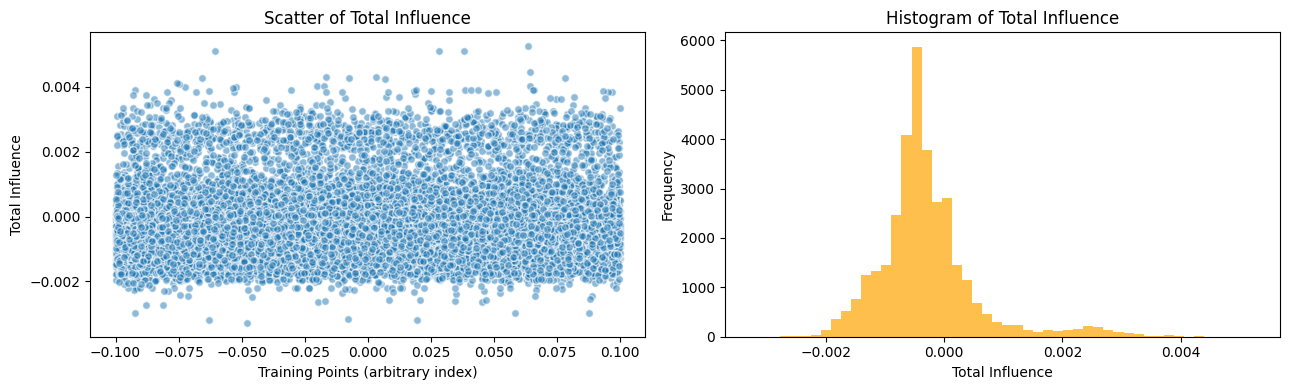

In [ ]:
train_ids = avginfls.index.tolist()
influence_vals = np.array(avginfls.values.tolist())
# Scatter plot
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)  # 1 row, 2 cols, first plot
y_coordinates = np.zeros_like(influence_vals) + np.random.uniform(-0.1, 0.1, len(influence_vals))
plt.scatter(y_coordinates, influence_vals, alpha=0.5, edgecolors='w', s=30)
plt.xlabel("Training Points (arbitrary index)")
plt.ylabel("Total Influence")
plt.title("Scatter of Total Influence")

# Histogram
plt.subplot(1, 2, 2)  # 1 row, 2 cols, second plot
plt.hist(influence_vals, bins=50, alpha=0.7, color='orange')
plt.xlabel("Total Influence")
plt.ylabel("Frequency")
plt.title("Histogram of Total Influence")

#plt.tight_layout()
plt.show()

         positive  negative
test_id                    
12          13176     20616
148         18027     15765
287          8516     25276
292         14781     19011
310         10248     23544
...           ...       ...
34733       10122     23670
34847        9716     24076
34955       17432     16360
34959       17884     15908
34965       10729     23063

[1000 rows x 2 columns]


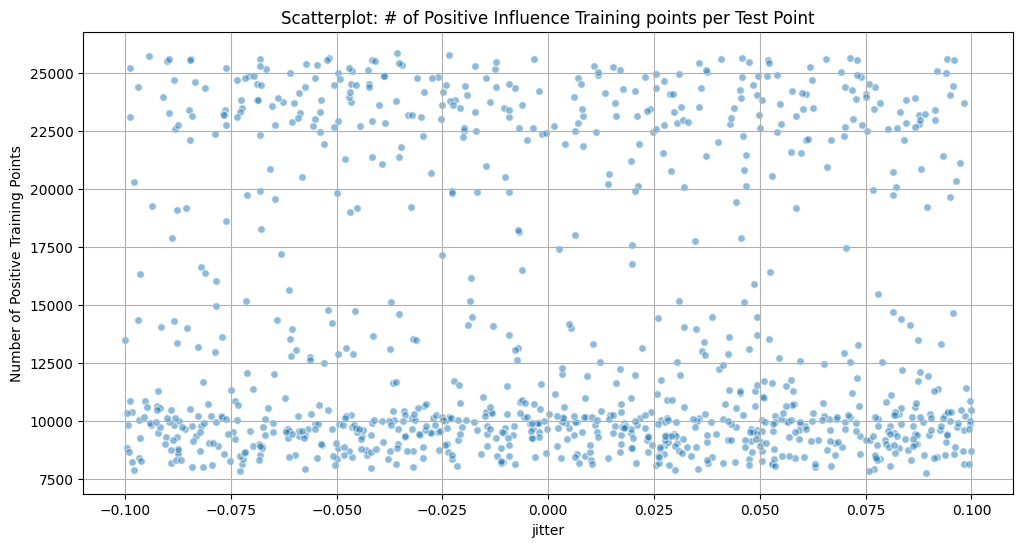

Text(0.5, 1.0, 'Histogram of Positive Training points per test')

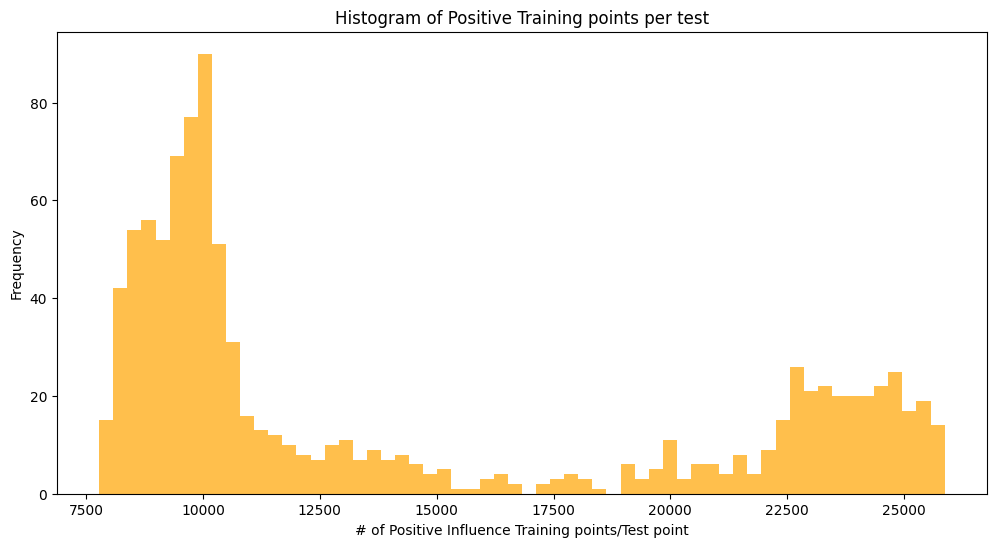

In [20]:
#Positive and harmful points:
df['positive'] = (df['influence'] >= 0).astype(int)
df['negative'] = (df['influence'] < 0).astype(int)
counts_dict = df.groupby('test_id')[['positive', 'negative']].sum()
print(counts_dict)

positive_counts=np.array(counts_dict['positive'].tolist())
test_ids=counts_dict.index.tolist()
plt.figure(figsize=(12,6))
y_coordinates = np.zeros_like(positive_counts) + np.random.uniform(-0.1, 0.1, len(positive_counts))
plt.scatter(y_coordinates, positive_counts, alpha=0.5, edgecolors='w', s=30)
plt.xlabel('jitter')
plt.ylabel('Number of Positive Training Points')
plt.title('Scatterplot: # of Positive Influence Training points per Test Point')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.hist(positive_counts, bins=60, alpha=0.7, color='orange')
plt.xlabel("# of Positive Influence Training points/Test point")
plt.ylabel("Frequency")
plt.title("Histogram of Positive Training points per test")



In [ ]:
# Visualize Influence Results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def visualize_influence_results(influence_results, test_id=0, top_k=10, show_train_data=False):
    """
    Visualize influence results for a specific test sample.
    
    Args:
        influence_results: Dictionary returned by calc_influence_dataset
        test_id: Index of test sample to visualize
        top_k: Number of top helpful/harmful training samples to show
        show_train_data: If True, show actual feature values of training samples
    """
    if str(test_id) not in influence_results:
        print(f"Test ID {test_id} not found in results. Available IDs: {list(influence_results.keys())[:10]}")
        return
    
    result = influence_results[str(test_id)]
    influences = result['influence']
    harmful_indices = result['harmful'][:top_k]
    helpful_indices = result['helpful'][:top_k]
    
    # Create DataFrame for easier manipulation
    df = pd.DataFrame({
        'train_idx': range(len(influences)),
        'influence': influences
    })
    
    # Get top helpful and harmful
    helpful_df = df.loc[helpful_indices].copy()
    helpful_df = helpful_df.sort_values('influence', ascending=False)
    
    harmful_df = df.loc[harmful_indices].copy()
    harmful_df = harmful_df.sort_values('influence', ascending=True)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot harmful influences
    axes[0].barh(range(len(harmful_df)), harmful_df['influence'].values, color='coral', alpha=0.7)
    axes[0].set_yticks(range(len(harmful_df)))
    axes[0].set_yticklabels([f"Train {idx}" for idx in harmful_df['train_idx'].values])
    axes[0].set_xlabel('Influence Score (negative = harmful)', fontsize=11)
    axes[0].set_title(f'Top {top_k} Most Harmful Training Samples\n(Test Sample {test_id}, Label: {result["label"]})', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Plot helpful influences
    axes[1].barh(range(len(helpful_df)), helpful_df['influence'].values, color='lightgreen', alpha=0.7)
    axes[1].set_yticks(range(len(helpful_df)))
    axes[1].set_yticklabels([f"Train {idx}" for idx in helpful_df['train_idx'].values])
    axes[1].set_xlabel('Influence Score (positive = helpful)', fontsize=11)
    axes[1].set_title(f'Top {top_k} Most Helpful Training Samples\n(Test Sample {test_id}, Label: {result["label"]})', fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Influence Analysis Summary for Test Sample {test_id}")
    print(f"{'='*60}")
    print(f"Test Label: {result['label']}")
    print(f"Calculation Time: {result['time_calc_influence_s']:.2f} seconds")
    print(f"\nInfluence Statistics:")
    print(f"  Mean: {np.mean(influences):.6f}")
    print(f"  Std:  {np.std(influences):.6f}")
    print(f"  Min:  {np.min(influences):.6f}")
    print(f"  Max:  {np.max(influences):.6f}")
    print(f"\nMost Harmful Training Sample: {harmful_indices[0]} (influence: {influences[harmful_indices[0]]:.6f})")
    print(f"Most Helpful Training Sample: {helpful_indices[0]} (influence: {influences[helpful_indices[0]]:.6f})")
    
    # Optionally show training data for top samples
    if show_train_data and 'X_train' in globals():
        print(f"\n{'='*60}")
        print("Top Helpful Training Sample Features:")
        print(f"{'='*60}")
        top_helpful_idx = helpful_indices[0]
        top_helpful_features = pd.DataFrame({
            'feature': features,
            'value': X_train[top_helpful_idx]
        })
        print(top_helpful_features.to_string(index=False))
        
        print(f"\n{'='*60}")
        print("Top Harmful Training Sample Features:")
        print(f"{'='*60}")
        top_harmful_idx = harmful_indices[0]
        top_harmful_features = pd.DataFrame({
            'feature': features,
            'value': X_train[top_harmful_idx]
        })
        print(top_harmful_features.to_string(index=False))

# Visualize results for first test sample
if 'influence_results' in globals():
    visualize_influence_results(influence_results, test_id=0, top_k=10, show_train_data=True)
else:
    print("Run the influence calculation cell first")


## Local Rule Extraction using Influence Functions

This section extracts human-readable local decision rules for TabNet predictions using influence functions. The pipeline:

1. **Identify Influential Training Samples**: Uses influence functions to find training points that support (S_plus) or oppose (S_minus) the prediction
2. **Cluster Influential Samples**: Groups influential samples by features, model predictions, and influence sign
3. **Derive Symbolic Rules**: Extracts decision tree rules from each cluster to explain "why" and "what if" scenarios

These local rules are designed to be aggregated later into global rules (GLocalX-style).


In [ ]:
# Local Rule Extraction Pipeline
from utilities.influence.local_rule_extraction import LocalRuleExtractor

# Initialize rule extractor
if 'torch_model' in globals() and 'features' in globals() and 'X_train' in globals() and 'y_train' in globals():
    rule_extractor = LocalRuleExtractor(
        model=torch_model,
        feature_names=features,
        n_clusters=3,  # Number of clusters for influential samples
        max_depth=4,   # Max depth for decision trees (keep shallow for interpretability)
        min_samples_split=10  # Minimum samples to split a node
    )
    print("Rule extractor initialized successfully!")
    print(f"Features: {len(features)}")
    print(f"Training samples: {len(X_train)}")
else:
    print("Error: Required variables (torch_model, features, X_train, y_train) not found.")
    print("Please run the model training and influence calculation cells first.")


In [ ]:
# Extract Local Rules for a Test Sample

if 'influence_results' in globals() and 'rule_extractor' in globals():
    # Extract rules for the first test sample (test_id=0 in influence_results)
    # Note: The test_id in influence_results corresponds to indices in test_loader
    # We need to map this to actual test set indices
    
    test_id = 0  # Change this to analyze different test samples
    
    print(f"Extracting local rules for test sample {test_id}...")
    print("This may take a few minutes...")
    
    # Extract rules
    # Note: test_id in influence_results refers to test set indices
    local_rules = rule_extractor.extract_local_rules(
        influence_results=influence_results,
        test_id=test_id,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test if 'X_test' in globals() else None,  # Provide test set if available
        top_k=50,  # Number of top helpful/harmful samples to consider
        clustering_method='kmeans'  # or 'dbscan'
    )
    
    print(f"\n{'='*70}")
    print(f"Local Rules Extracted for Test Sample {test_id}")
    print(f"{'='*70}")
    print(f"Test Prediction: {local_rules['test_prediction']}")
    print(f"Number of Helpful Samples: {len(local_rules['helpful_samples'])}")
    print(f"Number of Harmful Samples: {len(local_rules['harmful_samples'])}")
    print(f"Number of Clusters: {local_rules['n_clusters']}")
    
else:
    print("Error: influence_results or rule_extractor not found.")
    print("Please run the influence calculation and rule extractor initialization cells first.")


In [ ]:
# Visualize and Display Extracted Rules

def display_local_rules(local_rules, feature_names):
    """Display extracted local rules in a human-readable format."""
    print(f"\n{'='*70}")
    print(f"LOCAL EXPLANATION RULES FOR TEST SAMPLE {local_rules['test_id']}")
    print(f"{'='*70}\n")
    
    print(f"Model Prediction: Class {local_rules['test_prediction']}\n")
    
    for cluster_id, cluster_info in local_rules['clusters'].items():
        if cluster_info['n_samples'] < 5:  # Skip very small clusters
            continue
            
        print(f"\n{'─'*70}")
        print(f"CLUSTER {cluster_id}")
        print(f"{'─'*70}")
        print(f"  Samples: {cluster_info['n_samples']}")
        print(f"  Dominant Label: {cluster_info['dominant_label']}")
        print(f"  Mean Influence: {cluster_info['mean_influence']:.6f}")
        
        if cluster_info['explanation_rule']:
            print(f"\n  📋 EXPLANATION RULE (Why this prediction?):")
            print(f"     {cluster_info['explanation_rule']}")
        
        if cluster_info['counterfactual_rule']:
            print(f"\n  🔄 COUNTERFACTUAL RULE (What needs to change?):")
            print(f"     {cluster_info['counterfactual_rule']}")
    
    print(f"\n{'='*70}")
    print("Note: These local rules can be aggregated across many instances")
    print("to discover global patterns (future: GLocalX-style aggregation)")
    print(f"{'='*70}\n")

# Display rules if available
if 'local_rules' in globals():
    display_local_rules(local_rules, features)
else:
    print("No local rules found. Please run the rule extraction cell first.")


In [ ]:
# Visualize Cluster Structure and Rule Coverage

def visualize_rule_clusters(local_rules, X_train, feature_names, top_features=5):
    """Visualize how clusters relate to features and influences."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if 'local_rules' not in globals():
        print("No local rules to visualize.")
        return
    
    # Get cluster data
    cluster_labels = np.array(local_rules['cluster_data']['cluster_labels'])
    influence_signs = np.array(local_rules['cluster_data']['influence_signs'])
    
    # Get features for influential samples
    all_indices = local_rules['helpful_samples'] + local_rules['harmful_samples']
    influential_features = X_train[all_indices]
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Cluster distribution by influence sign
    unique_clusters = np.unique(cluster_labels)
    cluster_influence_counts = []
    cluster_labels_list = []
    influence_type = []
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Skip noise
            continue
        mask = cluster_labels == cluster_id
        helpful_count = (influence_signs[mask] > 0).sum()
        harmful_count = (influence_signs[mask] < 0).sum()
        
        cluster_influence_counts.extend([helpful_count, harmful_count])
        cluster_labels_list.extend([f'Cluster {cluster_id}', f'Cluster {cluster_id}'])
        influence_type.extend(['Helpful', 'Harmful'])
    
    if cluster_influence_counts:
        df_cluster = pd.DataFrame({
            'Cluster': cluster_labels_list,
            'Count': cluster_influence_counts,
            'Type': influence_type
        })
        sns.barplot(data=df_cluster, x='Cluster', y='Count', hue='Type', ax=axes[0, 0])
        axes[0, 0].set_title('Cluster Distribution by Influence Type')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Feature importance across clusters (using variance)
    feature_variance = np.var(influential_features, axis=0)
    top_feature_indices = np.argsort(feature_variance)[-top_features:][::-1]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    
    axes[0, 1].barh(range(len(top_feature_names)), feature_variance[top_feature_indices])
    axes[0, 1].set_yticks(range(len(top_feature_names)))
    axes[0, 1].set_yticklabels(top_feature_names)
    axes[0, 1].set_xlabel('Feature Variance')
    axes[0, 1].set_title(f'Top {top_features} Most Variable Features in Influential Samples')
    axes[0, 1].invert_yaxis()
    
    # 3. Cluster separation (2D projection using PCA on top features)
    from sklearn.decomposition import PCA
    
    if len(influential_features) > 1:
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(influential_features[:, top_feature_indices])
        
        scatter = axes[1, 0].scatter(features_2d[:, 0], features_2d[:, 1], 
                                    c=cluster_labels, cmap='tab10', 
                                    alpha=0.6, s=50)
        axes[1, 0].set_xlabel(f'PC1 (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
        axes[1, 0].set_ylabel(f'PC2 (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
        axes[1, 0].set_title('Cluster Visualization (2D Projection)')
        axes[1, 0].legend(*scatter.legend_elements(), title="Clusters")
        plt.colorbar(scatter, ax=axes[1, 0])
    
    # 4. Rule coverage: Show which clusters have valid rules
    cluster_ids = []
    has_explanation = []
    has_counterfactual = []
    n_samples_list = []
    
    for cluster_id, cluster_info in local_rules['clusters'].items():
        cluster_ids.append(f'Cluster {cluster_id}')
        has_explanation.append(1 if cluster_info['explanation_rule'] else 0)
        has_counterfactual.append(1 if cluster_info['counterfactual_rule'] else 0)
        n_samples_list.append(cluster_info['n_samples'])
    
    if cluster_ids:
        x = np.arange(len(cluster_ids))
        width = 0.35
        axes[1, 1].bar(x - width/2, has_explanation, width, label='Has Explanation Rule', color='lightblue')
        axes[1, 1].bar(x + width/2, has_counterfactual, width, label='Has Counterfactual Rule', color='lightcoral')
        axes[1, 1].set_xlabel('Cluster')
        axes[1, 1].set_ylabel('Rule Availability')
        axes[1, 1].set_title('Rule Coverage by Cluster')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(cluster_ids, rotation=45, ha='right')
        axes[1, 1].legend()
        axes[1, 1].set_ylim([0, 1.2])
        
        # Add sample counts as text
        for i, n_samples in enumerate(n_samples_list):
            axes[1, 1].text(i, 1.1, f'n={n_samples}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary:")
    print(f"  Total clusters: {local_rules['n_clusters']}")
    print(f"  Clusters with explanation rules: {sum(1 for c in local_rules['clusters'].values() if c['explanation_rule'])}")
    print(f"  Clusters with counterfactual rules: {sum(1 for c in local_rules['clusters'].values() if c['counterfactual_rule'])}")

# Visualize if rules are available
if 'local_rules' in globals():
    visualize_rule_clusters(local_rules, X_train, features, top_features=10)
else:
    print("No local rules to visualize. Please run the rule extraction cell first.")


In [ ]:
# Additional Visualization: Compare Multiple Test Samples or Load Saved Results

# Option 1: Load previously saved results
import json
from pathlib import Path

def load_saved_influence_results(results_path='outdir/influence_results.json'):
    """Load influence results from a saved JSON file."""
    path = Path(results_path)
    if path.exists():
        with open(path, 'r') as f:
            return json.load(f)
    else:
        print(f"Results file not found at {results_path}")
        return None

# Uncomment to load saved results:
# influence_results = load_saved_influence_results()

# Option 2: Compare influences across multiple test samples
def compare_test_samples(influence_results, test_ids=[0, 1, 2], top_k=5):
    """Compare top helpful/harmful training samples across multiple test samples."""
    fig, axes = plt.subplots(len(test_ids), 2, figsize=(14, 4*len(test_ids)))
    if len(test_ids) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, test_id in enumerate(test_ids):
        if str(test_id) not in influence_results:
            print(f"Skipping test ID {test_id} (not found)")
            continue
            
        result = influence_results[str(test_id)]
        influences = result['influence']
        harmful_indices = result['harmful'][:top_k]
        helpful_indices = result['helpful'][:top_k]
        
        harmful_infl = [influences[i] for i in harmful_indices]
        helpful_infl = [influences[i] for i in helpful_indices]
        
        # Plot harmful
        axes[idx, 0].barh(range(len(harmful_infl)), harmful_infl, color='coral', alpha=0.7)
        axes[idx, 0].set_yticks(range(len(harmful_indices)))
        axes[idx, 0].set_yticklabels([f"T{i}" for i in harmful_indices])
        axes[idx, 0].set_xlabel('Influence')
        axes[idx, 0].set_title(f'Test {test_id} (Label: {result["label"]}) - Harmful')
        axes[idx, 0].invert_yaxis()
        axes[idx, 0].grid(axis='x', alpha=0.3)
        
        # Plot helpful
        axes[idx, 1].barh(range(len(helpful_infl)), helpful_infl, color='lightgreen', alpha=0.7)
        axes[idx, 1].set_yticks(range(len(helpful_indices)))
        axes[idx, 1].set_yticklabels([f"T{i}" for i in helpful_indices])
        axes[idx, 1].set_xlabel('Influence')
        axes[idx, 1].set_title(f'Test {test_id} (Label: {result["label"]}) - Helpful')
        axes[idx, 1].invert_yaxis()
        axes[idx, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Option 3: Distribution of influence scores
def plot_influence_distribution(influence_results, test_id=0):
    """Plot the distribution of influence scores for a test sample."""
    if str(test_id) not in influence_results:
        print(f"Test ID {test_id} not found")
        return
    
    influences = influence_results[str(test_id)]['influence']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(influences, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero influence')
    axes[0].set_xlabel('Influence Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of Influence Scores\n(Test Sample {test_id})')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    axes[1].boxplot(influences, vert=True)
    axes[1].set_ylabel('Influence Score')
    axes[1].set_title(f'Box Plot of Influence Scores\n(Test Sample {test_id})')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nInfluence Distribution Statistics for Test Sample {test_id}:")
    print(f"  Median: {np.median(influences):.6f}")
    print(f"  Q1 (25th percentile): {np.percentile(influences, 25):.6f}")
    print(f"  Q3 (75th percentile): {np.percentile(influences, 75):.6f}")
    print(f"  IQR: {np.percentile(influences, 75) - np.percentile(influences, 25):.6f}")


if 'influence_results' in globals():
    # Compare multiple test samples
    compare_test_samples(influence_results, test_ids=[0, 1, 2], top_k=5)
    
    # Plot distribution for first test sample
    plot_influence_distribution(influence_results, test_id=0)


## Global Rule Set from Local Rule Set